<a href="https://colab.research.google.com/github/TomoShishido/img2xml/blob/main/img2xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# img2Mxml (sheetmusic2musicxml): produce a music xml file from a sheet music image (.jpg or .png)

In [1]:

!git clone https://github.com/TomoShishido/img2xml  # clone repo
!pip install -qr img2xml/bfaaap/yolov5/requirements.txt  # install dependencies (ignore errors)
%cd /content/img2xml/bfaaap/yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [3]:
!ls -l /content/img2xml/bfaaap/

total 64
drwxr-xr-x 2 root root  4096 Jul 10 12:13 adjustalphabeta
drwxr-xr-x 3 root root  4096 Jul 10 12:13 alignmeasures
-rw-r--r-- 1 root root  8735 Jul 10 12:13 detectionintegration.py
drwxr-xr-x 4 root root  4096 Jul 10 12:13 enlargemeasures
drwxr-xr-x 2 root root  4096 Jul 10 12:13 leveloriginalimg
drwxr-xr-x 2 root root  4096 Jul 10 12:15 makeyolomusicdict
drwxr-xr-x 5 root root  4096 Jul 10 12:13 musicdata
-rw-r--r-- 1 root root  1630 Jul 10 12:13 requirements_for_localenv.txt
-rw-r--r-- 1 root root    77 Jul 10 12:13 requirements.txt
-rw-r--r-- 1 root root 10358 Jul 10 12:13 systemintegration.py
drwxr-xr-x 3 root root  4096 Jul 10 12:13 yoloToxml
drwxr-xr-x 5 root root  4096 Jul 10 12:13 yolov5


In [4]:
from google.colab import drive
drive.mount('/content/g')

Mounted at /content/g


In [5]:
!ls /content/g/

MyDrive


In [6]:
# place yolov5 weights in /bfaaap/yolov5/weightsstock/
!mkdir /content/img2xml/bfaaap/yolov5/weightsstock
%cd /content/img2xml/bfaaap/yolov5/weightsstock
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hTrPCL30Xbi9-qHyqb2lAcI_FoFdk0HK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hTrPCL30Xbi9-qHyqb2lAcI_FoFdk0HK" -O img2xml_weights.zip && rm -rf /tmp/cookies.txt


/content/img2xml/bfaaap/yolov5/weightsstock
--2021-07-10 12:16:21--  https://docs.google.com/uc?export=download&confirm=eYFL&id=1hTrPCL30Xbi9-qHyqb2lAcI_FoFdk0HK
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-3c-docs.googleusercontent.com/docs/securesc/eg0jif7l1sd8tleo6magskiol64kel2c/0a6e40rtsj18g47nr7r3fni0m4sfreib/1625919375000/06160437493041457037/14773855032163739586Z/1hTrPCL30Xbi9-qHyqb2lAcI_FoFdk0HK?e=download [following]
--2021-07-10 12:16:22--  https://doc-14-3c-docs.googleusercontent.com/docs/securesc/eg0jif7l1sd8tleo6magskiol64kel2c/0a6e40rtsj18g47nr7r3fni0m4sfreib/1625919375000/06160437493041457037/14773855032163739586Z/1hTrPCL30Xbi9-qHyqb2lAcI_FoFdk0HK?e=download
Resolving doc-14-3c-docs.googleusercontent.com (doc-14-3c-docs.googleusercontent.com)... 74.12

In [7]:
!unzip img2xml_weights.zip

Archive:  img2xml_weights.zip
  inflating: last_0.94_body4_20210208.pt  
  inflating: last_0.95_staff4_20201230.pt  
  inflating: last_0.99_Accidental2_20210209.pt  
  inflating: last_0.99_armbeam2_20210214.pt  
  inflating: last_0.99_Clef3_20210129.pt  
  inflating: last_0.99_rest1_20210107.pt  


In [8]:
import cv2
import glob
import os
import subprocess
import shutil
import numpy as np
import math
from enum import Enum, auto
import copy
from itertools import chain
import time
import subprocess
from IPython.display import Image, clear_output  # to display images

%cd /content/img2xml/bfaaap/yolov5

#here, provide a FILE_PATH for a sheet music image (either .jpg or .png)
FILE_PATH ='/content/img2xml/bfaaap/musicdata/test0/test1.png'
#input base data for sheet music of interest:
tempo = 120 #
fifths = -1 #if the key signature after clef has three #, the number is 3 (positive integer); if the key signature has one b, the number is -1 (negative integer); if the key signature does't have any of them, the number is 0
beats = 3 #if the beat is 3/4, the "beats" is 3 and the "beat_type" is 4. 
beat_type = 2 #see the above
preset_measure_duration = 1024 * beats / beat_type #

/content/img2xml/bfaaap/yolov5


# actual performance of this test music piece (Sarabande by Handel)
 ## [YouTube](https://youtu.be/PEsBBFNyKBM)

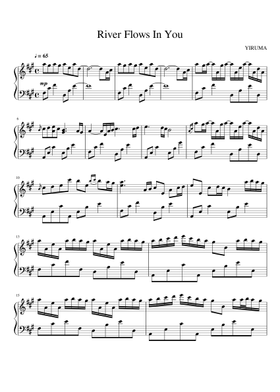

In [10]:
#show the original image
Image(filename=FILE_PATH, width=250) 

In [11]:
#First, level the original sheet music image
%cd /content/img2xml/bfaaap
from leveloriginalimg.leveloriginalimg import leveloriginalimg
#note that the FILE_PATH will be changed
FILE_PATH = leveloriginalimg(FILE_PATH)

/content/img2xml/bfaaap
0.02866221847606629


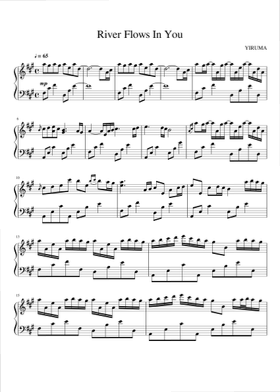

In [12]:
#show a leveled image
Image(filename=FILE_PATH, width=250) 

In [13]:
#extract staves with measures
#perform inference on sheet music
%cd /content/img2xml/bfaaap/yolov5
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff'

proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.95_staff4_20201230.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.75', '--source', FILE_PATH, '--save-txt'])
proc.wait()

/content/img2xml/bfaaap/yolov5


0

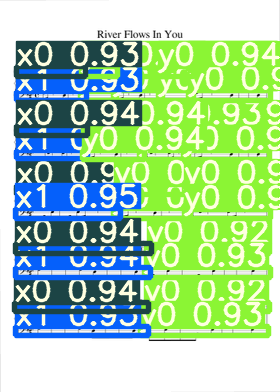

In [14]:
# check the measure inference result
files_temp = glob.glob(FILE_PATH)
#the resulting file after inference of measures
MEASURE_INFERENCE_RESULT_PATH = ''
for file_temp in files_temp:
    if file_temp.endswith('jpg') or file_temp.endswith('png'):
        basename = os.path.basename(file_temp)
        MEASURE_INFERENCE_RESULT_PATH = SAVE_DIRECTORY_PATH + '/' + basename
#show the measure inference results on the leveled sheet music image
Image(filename=MEASURE_INFERENCE_RESULT_PATH, width=900) 

In [15]:
#After the measure-recognizing model is applied to a piece of sheet music

#copy and move the relevant files under a dirctory ./musicdata/AAA/(staff/labels)
#sheet music (.jpg) provided in FILE_PATH
files_temp = glob.glob(FILE_PATH)
#To skip .txt files
for file_temp in files_temp:
    if file_temp.endswith('jpg') or file_temp.endswith('png'):
        img = cv2.imread(file_temp)
        dirname = os.path.dirname(file_temp)
        basename = os.path.basename(file_temp)
        cv2.imwrite(dirname + '/staff/labels/' + basename, img)


In [16]:
#generate measures 
%cd /content/img2xml/bfaaap
from alignmeasures.align_measures import generate_measures_in_eachstave_aslist
#sheet music provided in FILE_PATH
staves_with_measures_in_sheetmusic = generate_measures_in_eachstave_aslist(FILE_PATH)
print(f'the number of staves_with_measures_in_sheetmusic is {len(staves_with_measures_in_sheetmusic)}')
for i, each_staff in enumerate(staves_with_measures_in_sheetmusic):
    print(f'the number of measures in staff{i} is {len(each_staff)}')

/content/img2xml/bfaaap
pass through deleteOverlaps(staves_input)
adjusted_staves has 10 staves
0th staff has 5 measures
staff 0: center_y is 0.181122
1th staff has 5 measures
staff 1: center_y is 0.243622
2th staff has 4 measures
staff 2: center_y is 0.331633
3th staff has 4 measures
staff 3: center_y is 0.392857
4th staff has 3 measures
staff 4: center_y is 0.483418
5th staff has 3 measures
staff 5: center_y is 0.543367
6th staff has 2 measures
staff 6: center_y is 0.632653
7th staff has 2 measures
staff 7: center_y is 0.693878
8th staff has 2 measures
staff 8: center_y is 0.781888
9th staff has 2 measures
staff 9: center_y is 0.843112
the number of staves_with_measures_in_sheetmusic is 10
the number of measures in staff0 is 5
the number of measures in staff1 is 5
the number of measures in staff2 is 4
the number of measures in staff3 is 4
the number of measures in staff4 is 3
the number of measures in staff5 is 3
the number of measures in staff6 is 2
the number of measures in staff7 

In [17]:
#input whether staves are paired
areStavesPaired = True

#excise and enlarge each measure img at 412 x 412 pixels in each staff and stored in musicdata/AAA/measure/staff1/ or staff2/
from enlargemeasures.enlargeeachmeasure import produceResizedMeasuresFromAlignedStaves
#in the case of wide staff extraction, set staff_magnification = 1.2
staff_magnification = 1.2

produceResizedMeasuresFromAlignedStaves(img_FILE_PATH=FILE_PATH, aligned_staves=staves_with_measures_in_sheetmusic, isPaired=areStavesPaired, upper_margin=staff_magnification, lower_margin=staff_magnification)



eachmeasure has a width of 70 and a height of 10
eachmeasure has a width of 36 and a height of 10
eachmeasure has a width of 49 and a height of 9
eachmeasure has a width of 35 and a height of 10
eachmeasure has a width of 81 and a height of 11
eachmeasure has a width of 71 and a height of 10
eachmeasure has a width of 60 and a height of 10
eachmeasure has a width of 49 and a height of 10
eachmeasure has a width of 86 and a height of 10
eachmeasure has a width of 102 and a height of 9
eachmeasure has a width of 75 and a height of 10
eachmeasure has a width of 86 and a height of 10
eachmeasure has a width of 136 and a height of 10
eachmeasure has a width of 121 and a height of 10
eachmeasure has a width of 134 and a height of 9
eachmeasure has a width of 126 and a height of 9
eachmeasure has a width of 70 and a height of 9
eachmeasure has a width of 35 and a height of 9
eachmeasure has a width of 49 and a height of 10
eachmeasure has a width of 35 and a height of 10
eachmeasure has a wid

In [18]:
#level again each measure one by one
from leveloriginalimg.leveloriginalimg import leveleachmeasure

MEASURES_STAFF1_PATH = os.path.dirname(FILE_PATH) + '/measure/staff1/*'
files_temp = glob.glob(MEASURES_STAFF1_PATH)
for file_temp in files_temp:
    if file_temp.endswith('jpg') or file_temp.endswith('png'):
        FILE_DIR_PATH = os.path.dirname(file_temp)
        FILE_BASENAME = os.path.basename(file_temp)
        THIS_PATH = FILE_DIR_PATH + '/' + FILE_BASENAME
        result0 = leveleachmeasure(THIS_PATH)

MEASURES_STAFF2_PATH = os.path.dirname(FILE_PATH) + '/measure/staff2/*'
files_temp = glob.glob(MEASURES_STAFF2_PATH)
for file_temp in files_temp:
    if file_temp.endswith('jpg') or file_temp.endswith('png'):
        FILE_DIR_PATH = os.path.dirname(file_temp)
        FILE_BASENAME = os.path.basename(file_temp)
        THIS_PATH = FILE_DIR_PATH + '/' + FILE_BASENAME
        leveleachmeasure(THIS_PATH)

In [19]:
#apply individual models to the measures selected for staff 1 or 2

#work at the yolov5 directory
%cd /content/img2xml/bfaaap/yolov5

#processes in series (or in parallel)
start = time.time()
print(start)
#processes = []

#image source directory path for either staff1 or staff2


#For staff1


SOURCE_PATH = os.path.dirname(FILE_PATH) + '/measure/staff1/*'

#body
print('processing body 1')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff1/body'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.94_body4_20210208.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt', '--device', '0'])
proc.wait()
#processes.append((0, proc))

#armbeam
print('processing armbeam 1')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff1/armbeam'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_armbeam2_20210214.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt', '--device', '0'])
proc.wait()
#processes.append((1, proc))

#accidental
print('processing accidental 1')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff1/accidental'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_Accidental2_20210209.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((2, proc))

#rest
print('processing rest 1')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff1/rest'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_rest1_20210107.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((3, proc))

#clef
print('processing clef 1')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff1/clef'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_Clef3_20210129.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((4, proc))

#For staff2

SOURCE_PATH = os.path.dirname(FILE_PATH) + '/measure/staff2/*'

#body
print('processing body 2')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff2/body'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.94_body4_20210208.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((5, proc))

#armbeam
print('processing armbeam 2')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff2/armbeam'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_armbeam2_20210214.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((6, proc))

#accidental
print('processing accidental 2')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff2/accidental'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_Accidental2_20210209.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
# processes.append((7, proc))

#rest
print('processing rest 2')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff2/rest'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_rest1_20210107.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
#processes.append((8, proc))

#clef
print('processing clef 2')
SAVE_DIRECTORY_PATH = os.path.dirname(FILE_PATH) + '/staff2/clef'
proc = subprocess.Popen(['python','detect.py', '--weights', '/content/img2xml/bfaaap/yolov5/weightsstock/last_0.99_Clef3_20210129.pt', '--SAVE_PATH', SAVE_DIRECTORY_PATH ,'--img', '416', '--conf', '0.60', '--source', SOURCE_PATH, '--save-txt'])
proc.wait()
# processes.append((9, proc))

#for i, p in processes:
#    print(f'waiting process {i} to finish')
#    p.wait()

#end the time measurement
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

/content/img2xml/bfaaap/yolov5
1625919446.7474024
processing body 1
processing armbeam 1
processing accidental 1
processing rest 1
processing clef 1
processing body 2
processing armbeam 2
processing accidental 2
processing rest 2
processing clef 2
elapsed_time:60.22765302658081[sec]


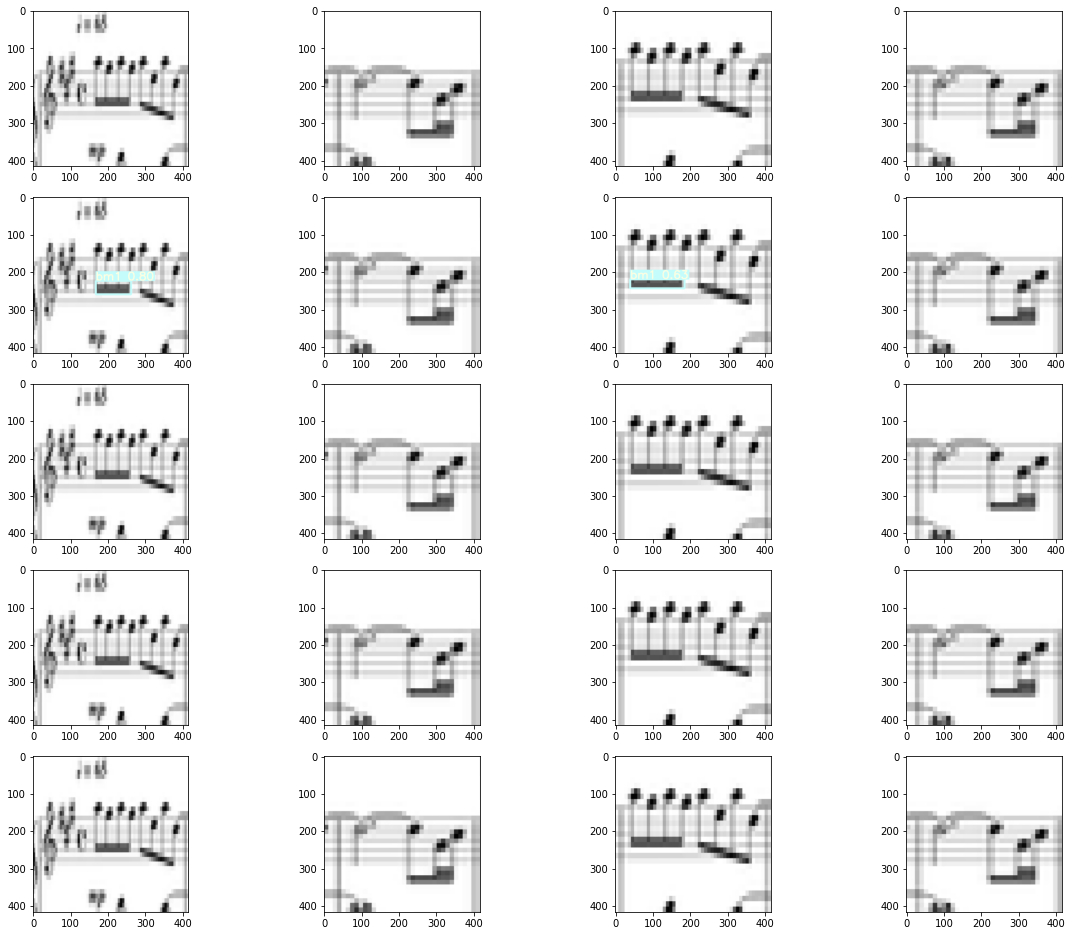

In [20]:
#check some of the inference results
import matplotlib.pyplot as plt
from PIL import Image
def show_images(images, figsize=(20,20), columns = 4):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

DISPLAY_FIG_PATHDIR = os.path.dirname(FILE_PATH)
images = []
featureTypes = ['body', 'armbeam', 'clef', 'accidental', 'rest']
numberOfFigs_eachType = 4

#staff1
for feature in featureTypes:
    for i in range(numberOfFigs_eachType):
        img = Image.open(f'{DISPLAY_FIG_PATHDIR}/staff1/{feature}/measure#{i:03}.png')
        images.append(img)
# #change /test0/ to your folder of interest
# img = Image.open('/content/img2xml/bfaaap/musicdata/test0/staff1/body/measure#000.jpg')
# images.append(img)

show_images(images)

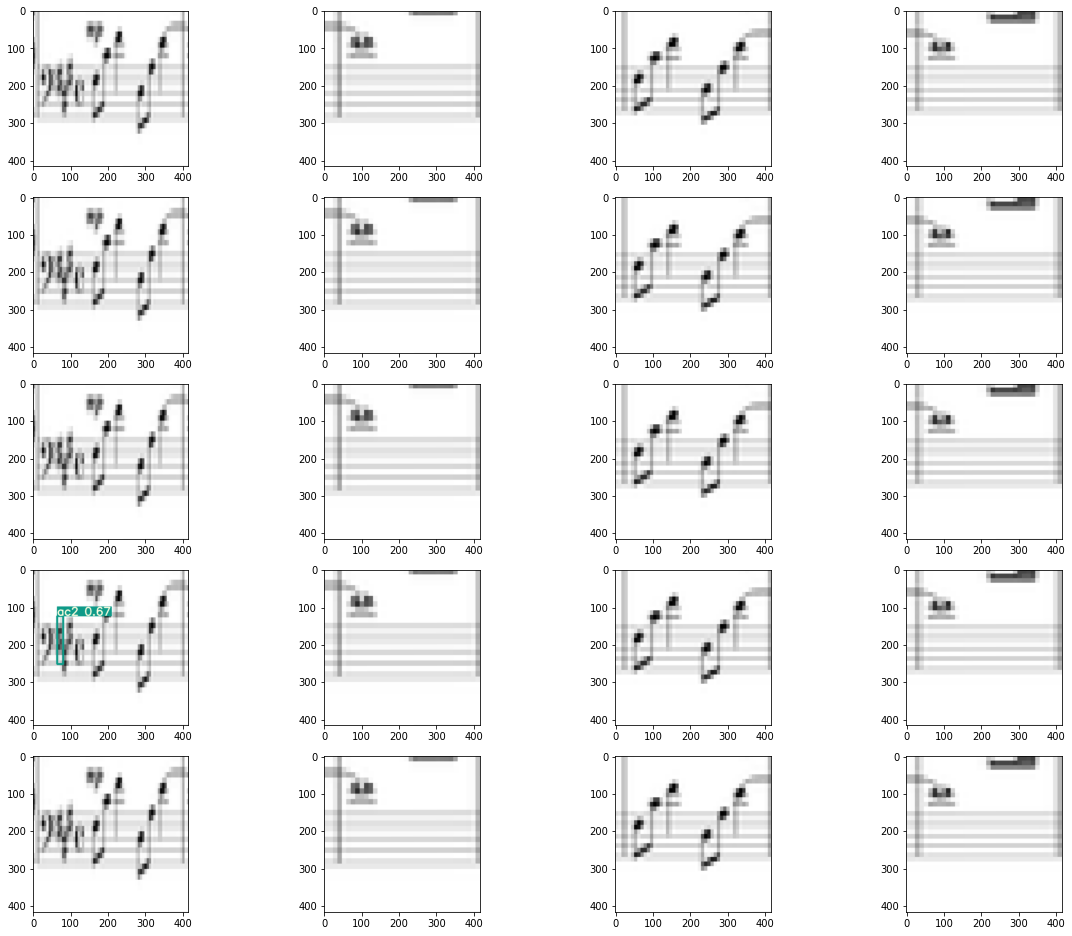

In [21]:
images = []

#staff2
for feature in featureTypes:
    for i in range(numberOfFigs_eachType):
        img = Image.open(f'{DISPLAY_FIG_PATHDIR}/staff2/{feature}/measure#{i:03}.png')
        images.append(img)
# #change /test0/ to your folder of interest
# img = Image.open('/content/img2xml/bfaaap/musicdata/test0/staff2/body/measure#000.jpg')
# images.append(img)

show_images(images)

In [22]:
#get the file path, basename, extention

files_temp = glob.glob(FILE_PATH) #"./tmp/*":beforehand prepare images and Yolov5 anotation files in ./tmp/subdirectory
#To skip .txt files
FILE_DIR_PATH = ''
FILE_BASENAME = ''
FILE_BASENAME_WITHOUTEXT = ''
for file_temp in files_temp:
    if file_temp.endswith('jpg') or file_temp.endswith('png'):
        img = cv2.imread(file_temp)
        FILE_DIR_PATH = os.path.dirname(file_temp)
        FILE_BASENAME = os.path.basename(file_temp)
        FILE_BASENAME_WITHOUTEXT = os.path.splitext(FILE_BASENAME)[0]
        cv2.imwrite(FILE_DIR_PATH + '/staff/labels/' + FILE_BASENAME, img)

In [23]:
%cd /content/img2xml/bfaaap
from alignmeasures.align_measures import generate_measures_in_eachstave_aslist
#sheet music provided in FILE_PATH
staves_with_measures_in_sheetmusic = generate_measures_in_eachstave_aslist(FILE_PATH)
print(f'the number of staves_with_measures_in_sheetmusic is {len(staves_with_measures_in_sheetmusic)}')
for i, each_staff in enumerate(staves_with_measures_in_sheetmusic):
    print(f'the number of measures in staff{i} is {len(each_staff)}')

/content/img2xml/bfaaap
pass through deleteOverlaps(staves_input)
adjusted_staves has 10 staves
0th staff has 5 measures
staff 0: center_y is 0.181122
1th staff has 5 measures
staff 1: center_y is 0.243622
2th staff has 4 measures
staff 2: center_y is 0.331633
3th staff has 4 measures
staff 3: center_y is 0.392857
4th staff has 3 measures
staff 4: center_y is 0.483418
5th staff has 3 measures
staff 5: center_y is 0.543367
6th staff has 2 measures
staff 6: center_y is 0.632653
7th staff has 2 measures
staff 7: center_y is 0.693878
8th staff has 2 measures
staff 8: center_y is 0.781888
9th staff has 2 measures
staff 9: center_y is 0.843112
the number of staves_with_measures_in_sheetmusic is 10
the number of measures in staff0 is 5
the number of measures in staff1 is 5
the number of measures in staff2 is 4
the number of measures in staff3 is 4
the number of measures in staff4 is 3
the number of measures in staff5 is 3
the number of measures in staff6 is 2
the number of measures in staff7 

In [24]:
#input wheter staves are paired
areStavesPaired = True

In [25]:
#generate ms sequence in each staff

from makeyolomusicdict.generatedictforxml import give_all_ms_in_eachmeasure_for_staff1or2

all_ms_in_eachmeasure_staff1, all_ms_in_eachmeasure_staff2 = give_all_ms_in_eachmeasure_for_staff1or2(isPaired=areStavesPaired, aligned_staves_input=staves_with_measures_in_sheetmusic, img_FILE_PATH=FILE_PATH)
print(f'the number of items in all_ms_in_eachmeasure_staff1 is {len(all_ms_in_eachmeasure_staff1)}')
aaa1 = all_ms_in_eachmeasure_staff1['measure#001']
print(f'aaa1 is {aaa1}')
print(f'the number of items in all_ms_in_eachmeasure_staff2 is {len(all_ms_in_eachmeasure_staff2)}')
bbb1 = all_ms_in_eachmeasure_staff2['measure#001']
print(f'bbb1 is {bbb1}')

the number of itmes in measures_in_staff1 is 16
the number of items in measures_in_staff2 is 16
are measures_in_staff1 and measures_in_staff２ identical?: False
the number of items in type_of_eachmeasure_staff1 is 16
type_of_eachmeasure_staff1 is {'measure#000': <MeasureType.x0: 1>, 'measure#001': <MeasureType.y0: 3>, 'measure#002': <MeasureType.y0: 3>, 'measure#003': <MeasureType.y0: 3>, 'measure#004': <MeasureType.y0: 3>, 'measure#005': <MeasureType.x0: 1>, 'measure#006': <MeasureType.y0: 3>, 'measure#007': <MeasureType.y0: 3>, 'measure#008': <MeasureType.y0: 3>, 'measure#009': <MeasureType.x0: 1>, 'measure#010': <MeasureType.y0: 3>, 'measure#011': <MeasureType.y0: 3>, 'measure#012': <MeasureType.x0: 1>, 'measure#013': <MeasureType.y0: 3>, 'measure#014': <MeasureType.x0: 1>, 'measure#015': <MeasureType.y0: 3>}
the number of items in type_of_eachmeasure_staff2 is 16
type_of_eachmeasure_staff2 is {'measure#000': <MeasureType.x1: 2>, 'measure#001': <MeasureType.y0: 3>, 'measure#002': <Me

In [26]:
#This information has been moved to the location where FILE_PATH was input
# #input base data for sheet music of interest:
# tempo = 120 #public data
# fifths = -1 #public data
# beats = 3 #public data
# beat_type = 2 #public data
# preset_measure_duration = 1024 * beats / beat_type #public data

#additional parameters
staff = 1
isWideStaff = False

In [27]:
from makeyolomusicdict.generatedictforxml import setCurrentAccidentalTable, generateMSsequenceForStaff1or2, Clef

#classはimportすること
current_clef = Clef.G
current_accidental_table_template ={'A':'', 'B':'', 'C':'', 'D':'', 'E':'', 'F':'', 'G':''}
current_accidental_table = setCurrentAccidentalTable(current_accidental_table_template, fifths)
ms_sequenceOfInterest_staff1 = generateMSsequenceForStaff1or2(all_ms_in_eachmeasure_input=all_ms_in_eachmeasure_staff1, current_accidental_table_input=current_accidental_table, staff=1, current_clef_input=current_clef, preset_measure_duration=preset_measure_duration, FILE_PATH=FILE_PATH, isWideStaff=isWideStaff)

#for staff2: check current_clef
current_clef = Clef.F
ms_sequenceOfInterest_staff2 = generateMSsequenceForStaff1or2(all_ms_in_eachmeasure_input=all_ms_in_eachmeasure_staff2, current_accidental_table_input=current_accidental_table, staff=2, current_clef_input=current_clef, preset_measure_duration=preset_measure_duration, FILE_PATH=FILE_PATH, isWideStaff=isWideStaff)

print(f'the number of items in all_ms_in_eachmeasure_staff1 is {len(all_ms_in_eachmeasure_staff1)}')
print(f'the number of items in all_ms_in_eachmeasure_staff2 is {len(all_ms_in_eachmeasure_staff2)}')

print(f'the number of items in ms_sequenceOfInterest_staff1 is {len(ms_sequenceOfInterest_staff1)}')
print(f'the number of items in ms_sequenceOfInterest_staff2 is {len(ms_sequenceOfInterest_staff2)}')

measure#000: alpha is 0.029 and beta is -0.003
the number of items in hsMSlist is 1
duration adjustment is not carried out
measure#001: alpha is 0.037 and beta is -0.005
the number of items in hsMSlist is 0
duration adjustment is not carried out
measure#002: alpha is 0.017 and beta is -0.005
the number of items in hsMSlist is 1
duration adjustment is not carried out
measure#003: alpha is 0.037 and beta is -0.005
the number of items in hsMSlist is 0
duration adjustment is not carried out
measure#004: alpha is -0.016 and beta is -0.005
the number of items in hsMSlist is 1
duration adjustment is not carried out
measure#005: alpha is 0.0 and beta is 0.002
the number of items in hsMSlist is 1
duration adjustment is not carried out
measure#006: alpha is -0.004 and beta is 0.0
the number of items in hsMSlist is 1
duration adjustment is not carried out
measure#007: alpha is 0.013 and beta is -0.005
the number of items in hsMSlist is 0
duration adjustment is not carried out
measure#008: alpha i

In [28]:
# generate a dictionary for ET

from makeyolomusicdict.generatedictforxml import generateDictForET_singlestaff

#for staff1
current_staff1_clef = Clef.G
dictionary_for_ET_staff1 = generateDictForET_singlestaff(ms_sequenceOfInterest_staff_input=ms_sequenceOfInterest_staff1, tempo=tempo, beats=beats, beat_type=beat_type, fifths=fifths, clef=current_staff1_clef)
part_content1 = dictionary_for_ET_staff1['part']
print(f'the number of items in dictionary_for_ET_staff1[0] is \n{len(part_content1)}')
#for staff2
current_staff2_clef = Clef.F
dictionary_for_ET_staff2 = generateDictForET_singlestaff(ms_sequenceOfInterest_staff_input=ms_sequenceOfInterest_staff2, tempo=tempo, beats=beats, beat_type=beat_type, fifths=fifths, clef=current_staff2_clef)
part_content2 = dictionary_for_ET_staff2['part']
print(f'the number of items in dictionary_for_ET_staff2[0] is \n{len(part_content2)}')

print(f'current_staff1_clef:{current_staff1_clef}\ncurrent_staff2_clef:{current_staff2_clef}')


the number of items in dictionary_for_ET_staff1[0] is 
16
the number of items in dictionary_for_ET_staff2[0] is 
16
current_staff1_clef:Clef.G
current_staff2_clef:Clef.F


In [29]:
#generate XML
from yoloToxml.yoloToxml import musicData2XML
import xml.etree.ElementTree as ET
from xml.dom import minidom


#for staff1

part_et = ET.Element('part')
part_et.attrib = {'id':'P1'}
part_et_1 = musicData2XML(part_et, dictionary_for_ET_staff1)

xmlstr_1 = minidom.parseString(ET.tostring(part_et_1)).toprettyxml(indent="   ")

#to delete <?xml version="1.0"　?> in line 1
xmlstr_1 = xmlstr_1[23:]
            

#read template.xml to prepare part_et XML data and generate the whole XML
wholeXML_staff1_text = ""
with open("/content/img2xml/bfaaap/yoloToxml/template.xml", 'r') as f:
    template_text = f.read()
    wholeXML_staff1_text = template_text +'\n' + xmlstr_1 +'\n</score-partwise>'

#save the resulting xml in ./xml/ directory
FILE_DIR_PATH
new_dir_path = FILE_DIR_PATH + '/xml'
os.makedirs(new_dir_path, exist_ok=True)
new_xml_filepath = new_dir_path + '/' + FILE_BASENAME_WITHOUTEXT + '_staff1.xml'
with open(new_xml_filepath, 'w') as f:
    f.write(wholeXML_staff1_text)

In [30]:
#for staff2

part_et = ET.Element('part')
part_et.attrib = {'id':'P1'}
part_et_2 = musicData2XML(part_et, dictionary_for_ET_staff2)

xmlstr_2 = minidom.parseString(ET.tostring(part_et_2)).toprettyxml(indent="   ")

#to delete <?xml version="1.0"　?> in line 1
xmlstr_2 = xmlstr_2[23:]            

#read template.xml to prepare part_et XML data and generate the whole XML
wholeXML_staff2_text = ""
with open("/content/img2xml/bfaaap/yoloToxml/template.xml", 'r') as f:
    template_text = f.read()
    wholeXML_staff2_text = template_text +'\n' + xmlstr_2 +'\n</score-partwise>'

#save the resulting xml in ./xml/ directory
FILE_DIR_PATH
new_dir_path = FILE_DIR_PATH + '/xml'
os.makedirs(new_dir_path, exist_ok=True)
new_xml_filepath = new_dir_path + '/' + FILE_BASENAME_WITHOUTEXT + '_staff2.xml'
with open(new_xml_filepath, 'w') as f:
    f.write(wholeXML_staff2_text)


# download the resulting xml file from "/content/img2xml/bfaaap/musicdata/test0/xml/*.xml"

### An Web [img2Mxml (sheetmusic2musicxml)](https://ui.saaipf.com/app/upload) application is available.

### Use, for instance, [Logic Pro](https://www.apple.com/jp/logic-pro/), [MuseScore](https://musescore.org/), [Sibelius First](https://my.avid.com/get/sibelius-first), or [xml2sound](https://ui.saaipf.com/app2/upload) to produce a sound from the resulting xml file.
